# Ejecución de estrategia de manera simple con la última actualización de manera local sin testnet.

<function matplotlib.pyplot.show(close=None, block=None)>

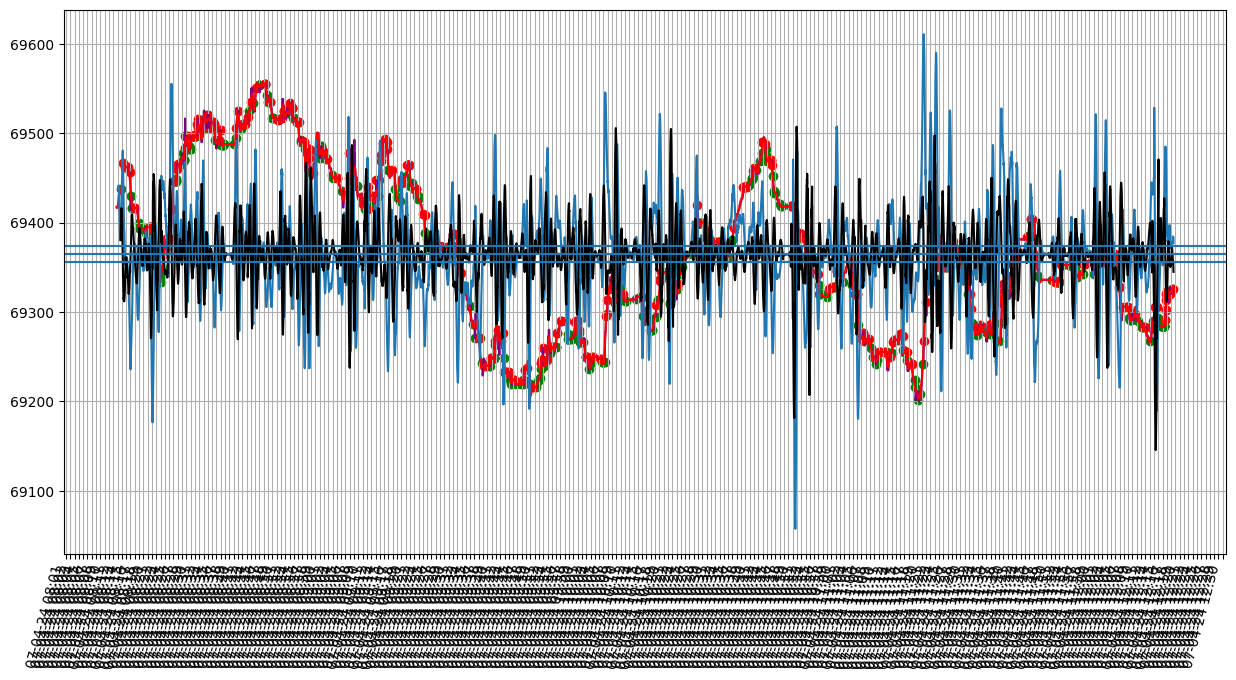

In [25]:
################################################################################################################################################################################
# Importamos las librerías necesarias y generamos conexión con Binance para descargar la lista de pares que binance maneja.
################################################################################################################################################################################
import pandas as pd
import os
import numpy as np
from datetime import datetime
import sympy as sp
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from binance import Client

client = Client()

##################################################
# Lista de parámetros.
##################################################
# Parámetros de interpolación.
###################################
smooth_interval = 60
smooth_exp = 3
###################################
# Parámetros de estrategia.
###################################
rango = 125
std_mult = 250
z_aprox = 0.009


##################################################################################################################################
# Descarga y limpieza de datos de 5 días en adelante
##################################################################################################################################
recent_data = pd.read_csv('../csvs/streaming/BTCUSDT.csv')
recent_data.columns = ['Tiempo','Par','Precio']
recent_data['Tiempo'] = recent_data.Tiempo.astype('datetime64')
recent_data = recent_data.set_index('Tiempo')
recent_data['Precio'] = recent_data.Precio.astype(float)
recent_data = recent_data.reset_index()

##################################################
# Interpolación (suavizado)  del Precio (OPEN) con SciPy y obtención de derivadas con su respectiva interpolación.
##################################################
recent_data['Interpolacion'] = sc.signal.savgol_filter(recent_data.Precio,smooth_interval,smooth_exp)
recent_data['Primer_Derivada'] = recent_data.Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
recent_data['PD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Primer_Derivada,smooth_interval,smooth_exp)
recent_data['Segunda_Derivada'] = recent_data.PD_Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
recent_data['SD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Segunda_Derivada,smooth_interval,smooth_exp)
recent_data['Tercer_Derivada'] = recent_data.SD_Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
recent_data['TD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Tercer_Derivada,smooth_interval,3)

######################################################################
# Agregamos el código necesario para encontrar los puntos exactos mínimos y máximos
######################################################################
initial_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[:1].item()),'%Y-%m-%d %H:%M:%S.%f')].index.item() + rango
final_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[-1:].item()),'%Y-%m-%d %H:%M:%S.%f')].index.item() - rango

# initial_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[60*45:60*45 + 1].item()),'%Y-%m-%d %H:%M:%S.%f')].index.item() + rango
# final_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[60*75:60*75 + 1].item()),'%Y-%m-%d %H:%M:%S.%f')].index.item() - rango

min_max_sd = pd.DataFrame(columns=['Derivada'])
lista_min_max = recent_data[initial_date_index:final_date_index][(recent_data[initial_date_index:final_date_index]['TD_Interpolacion'] >= -z_aprox) & (recent_data[initial_date_index:final_date_index]['TD_Interpolacion'] <= z_aprox)]
indices_min_max = lista_min_max.index.tolist()

max_points_idx = []
min_points_idx = []
mm_points_idx = []
pmin = 0
pmax = 0

for i in range(len(indices_min_max)):
    PMSD = indices_min_max[i]
    if recent_data.SD_Interpolacion[PMSD:PMSD+1].item() > 0:
        if (abs(recent_data.SD_Interpolacion[i]*1000) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
            pmax = recent_data.SD_Interpolacion[PMSD]
        for i in range(rango+1):
            if (i > PMSD) | (PMSD+i >= indices_min_max[-1:][0]):
                break
            elif (recent_data.SD_Interpolacion[PMSD-i] > pmax) & (abs(recent_data.SD_Interpolacion[PMSD-i]*1000) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
                pmax_idx = PMSD-i
            elif (recent_data.SD_Interpolacion[PMSD+i] > pmax) & (abs(recent_data.SD_Interpolacion[PMSD+i]*1000) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
                pmax_idx = PMSD+i
        max_points_idx.append(pmax_idx)
    elif recent_data.SD_Interpolacion[PMSD:PMSD+1].item() < 0:
        if (abs(recent_data.SD_Interpolacion[i]*1000) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
            pmin = recent_data.SD_Interpolacion[PMSD]
        for i in range(rango+1):
            if (i > PMSD) | (PMSD+i >= indices_min_max[-1:][0]):
                break
            elif (recent_data.SD_Interpolacion[PMSD-i] < pmin) & (abs(recent_data.SD_Interpolacion[PMSD-i]*1000) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
                pmin_idx = PMSD-i
            elif (recent_data.SD_Interpolacion[PMSD+i] < pmin) & (abs(recent_data.SD_Interpolacion[PMSD+i]*1000) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
                pmin_idx = PMSD+i
        min_points_idx.append(pmin_idx)
max_points_idx = list(set(max_points_idx))
min_points_idx = list(set(min_points_idx))
max_points_idx.sort()
min_points_idx.sort()
close_points_max = []
close_points_min = []
for lista in [max_points_idx,min_points_idx]:
    for i in range(len(lista)-1):
        if lista[i+1]-lista[i] == 1:
            if lista == max_points_idx:
                close_points_max.append(i+1)
            else:
                close_points_min.append(i+1)
    if lista == max_points_idx:
        for idx in sorted(close_points_max,reverse=True):
            del lista[idx]
    else:
        for idx in sorted(close_points_min,reverse=True):
            del lista[idx]


##################################################################################################################################
# Gráfica final del backtesting sobre nuestro análisis con puntos de compra y venta.
##################################################################################################################################
mp = recent_data.Precio[initial_date_index:final_date_index].mean()
plt.figure(figsize=(15,8))
plt.plot(recent_data.Tiempo[initial_date_index-120:final_date_index],recent_data.Precio[initial_date_index-120:final_date_index].multiply(1),color='purple')
plt.plot(recent_data.Tiempo[initial_date_index-120:final_date_index],recent_data.Interpolacion[initial_date_index-120:final_date_index].multiply(1),color='red')
plt.plot(recent_data.Tiempo[initial_date_index-120:final_date_index],recent_data.PD_Interpolacion[initial_date_index-120:final_date_index].multiply(100)+mp)
plt.plot(recent_data.Tiempo[initial_date_index-120:final_date_index],recent_data.SD_Interpolacion[initial_date_index-120:final_date_index].multiply(1000)+mp,color='k')
plt.scatter(recent_data.Tiempo.iloc[max_points_idx],recent_data.Precio.iloc[max_points_idx],color='g')
plt.scatter(recent_data.Tiempo.iloc[min_points_idx],recent_data.Precio.iloc[min_points_idx],color='r')
plt.grid(visible=True)

# Set minor tick locations.
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
# plt.gca().xaxis.set_minor_locator(minorLocator)
plt.gcf().autofmt_xdate()
# Set grid to use minor tick locations. 
plt.grid(which = 'minor')
plt.xticks(rotation=75)
plt.axhline(mp)
plt.axhline(np.std(recent_data.SD_Interpolacion)*std_mult + mp)
plt.axhline(mp - np.std(recent_data.SD_Interpolacion)*std_mult)
plt.show

In [21]:
recent_data

,Tiempo,Par,Precio,Interpolacion,Primer_Derivada,PD_Interpolacion,Segunda_Derivada,SD_Interpolacion,Tercer_Derivada,TD_Interpolacion
0,2024-04-07 08:12:42.369,BTCUSDT,69417.56,69419.709069,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-04-07 08:12:43.641,BTCUSDT,69417.55,69419.015003,-0.545649,NaN,NaN,NaN,NaN,NaN
2,2024-04-07 08:12:44.744,BTCUSDT,69417.55,69418.400113,-0.557471,NaN,NaN,NaN,NaN,NaN
3,2024-04-07 08:12:45.775,BTCUSDT,69417.56,69417.862024,-0.521909,NaN,NaN,NaN,NaN,NaN
4,2024-04-07 08:12:46.833,BTCUSDT,69417.55,69417.398365,-0.438241,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
14550,2024-04-07 12:20:42.271,BTCUSDT,69291.50,69291.495398,0.000016,0.002393,0.000106,0.000051,-0.001106,-0.001055
14551,2024-04-07 12:20:43.464,BTCUSDT,69291.50,69291.495412,0.000011,0.002374,-0.000015,-0.001096,-0.000961,-0.001277
14552,2024-04-07 12:20:44.843,BTCUSDT,69291.49,69291.495425,0.000009,0.002234,-0.000102,-0.002428,-0.000966,-0.001515
14553,2024-04-07 12:20:45.398,BTCUSDT,69291.50,69291.495437,0.000022,0.001961,-0.000493,-0.003954,-0.002749,-0.001770


In [28]:
pmax_df = recent_data.iloc[max_points_idx].loc[:,['Tiempo','Precio']]
pmax_df['Accion'] = 'C'
pmin_df = recent_data.iloc[min_points_idx].loc[:,['Tiempo','Precio']]
pmin_df['Accion'] = 'V'
vc_df = pd.concat([pmax_df,pmin_df],axis=1)
vc_df = vc_df.reset_index()
vc_df = vc_df.set_index('index')
vc_df = pd.concat([pmax_df,pmin_df],axis=0)
vc_df = vc_df.sort_index()
del_idx = []
vc_df = vc_df.reset_index()
for i in vc_df.index:
    try:
        if vc_df.Accion[i+1] == vc_df.Accion[i]:
            del_idx.append(i+1)
    except:
        pass
vc_df.drop(del_idx,inplace=True)
vc_df = vc_df.reset_index(drop=True)
vc_df['Diferencia_Precio_USDT'] = pd.Series(dtype='float')
for i in range(len(vc_df)-1):
    vc_df['Diferencia_Precio_USDT'][i+1] = (vc_df.Precio[i+1] - vc_df.Precio[i]) * 0.01
profits = 0
for i in range(len(vc_df)-1):
    if vc_df.Accion[i] == 'C' and vc_df.Diferencia_Precio_USDT[i+1] > 0:
        profits += vc_df.Diferencia_Precio_USDT[i+1]
    elif vc_df.Accion[i] == 'C' and vc_df.Diferencia_Precio_USDT[i+1] < 0:
        profits -= vc_df.Diferencia_Precio_USDT[i+1]
    elif vc_df.Accion[i] == 'V' and vc_df.Diferencia_Precio_USDT[i+1] > 0:
        profits += vc_df.Diferencia_Precio_USDT[i+1]
    elif vc_df.Accion[i] == 'V' and vc_df.Diferencia_Precio_USDT[i+1] < 0:
        profits -= vc_df.Diferencia_Precio_USDT[i+1]
profits

C:\Users\tinma\AppData\Local\Temp\ipykernel_32088\1831528618.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vc_df['Diferencia_Precio_USDT'][i+1] = (vc_df.Precio[i+1] - vc_df.Precio[i]) * 0.01


31.491200000000664

In [9]:
vc_df

,index,Tiempo,Precio,Accion,Diferencia_Precio_USDT
0,2736,2024-04-07 08:59:32.106,69500.00,V,NaN
1,2776,2024-04-07 09:00:12.222,69479.98,C,-1.0010
2,2816,2024-04-07 09:00:52.285,69480.00,V,0.0010
3,3093,2024-04-07 09:05:32.895,69416.72,C,-3.1640
4,3125,2024-04-07 09:06:05.505,69433.63,V,0.8455
5,3143,2024-04-07 09:06:23.373,69433.62,C,-0.0005
6,3181,2024-04-07 09:07:01.049,69482.44,V,2.4410
7,3212,2024-04-07 09:07:32.809,69450.00,C,-1.6220
8,3245,2024-04-07 09:08:06.610,69477.43,V,1.3715
9,3397,2024-04-07 09:10:41.839,69415.59,C,-3.0920
